In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mesa.batchrunner import BatchRunnerMP
from mesa.batchrunner import BatchRunner
from SALib.sample import saltelli
from SALib.analyze import sobol
import pandas as pd
from itertools import combinations
from BaseModel2Agents import SchellingModel

In [2]:

parameters = {
    'num_vars': 5,
    'names': ['density', 'p_random', 'pay_m', 'min_tenure', 'u_threshold'],
    'bounds': [[0.6, 0.95], [0.05, 0.2], [3, 7], [3, 6], [7, 9.5]]
}

pretty_names = {
    'density': 'Density',
    'p_random': 'Random-move Prob.',
    'pay_m': 'Payoff m',
    'min_tenure': 'Min. tenure',
    'u_threshold': 'U. threshold',
}
single_labels = [pretty_names[n] for n in parameters['names']]
pair_labels   = [
    f"{pretty_names[a]} & {pretty_names[b]}"
    for a, b in combinations(parameters['names'], 2)
]

model_reporters = {"dissimilarity": lambda m: m.dissimilarity[-1],
                   "exposure": lambda m: m.exposure[-1]}

replicates = 10
model_steps = 10
distinct_samples = 16
param_values = saltelli.sample(parameters, distinct_samples, calc_second_order=True)

C:\Users\JobMa\AppData\Local\Temp\ipykernel_9808\184551296.py:26: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(parameters, distinct_samples, calc_second_order=True)


In [5]:
import numpy as np
import pandas as pd
from SALib.sample import saltelli
from SALib.analyze import sobol
from concurrent.futures import ProcessPoolExecutor, as_completed
from BaseModel2Agents import SchellingModel


def run_single(params, run_id):
    """Top‐level for pickling."""
    try:
        m = SchellingModel(**params)
        for _ in range(model_steps):
            m.step()
        return { **params,
                 'Run': run_id,
                 'dissimilarity': m.dissimilarity[-1],
                 'exposure': m.exposure[-1] }
    except Exception as e:
        return {'Run': run_id, 'error': repr(e)}

if __name__ == '__main__':
    # Build all tasks
    all_tasks = []
    for rid in range(replicates * len(param_values)):
        vals = param_values[rid % len(param_values)]
        params = dict(zip(parameters['names'], vals))
        all_tasks.append((params, rid))

    # Dispatch
    with ProcessPoolExecutor(max_workers=8) as exe:
        futures = [exe.submit(run_single, p, rid) for p, rid in all_tasks]
        results = []
        for fut in as_completed(futures):
            results.append(fut.result())

    df = pd.DataFrame(results)
    # Inspect errors:
    if 'error' in df.columns:
        print("Errors encountered in the following runs:")
        print(df[df['error'].notna()][['Run','error']])

    # Then Sobol analysis and plotting...


    # 6) Sobol analysis
    Si_dissimilarity = sobol.analyze(parameters, df['dissimilarity'].values,
                            calc_second_order=True, print_to_console=False)
    Si_exposure  = sobol.analyze(parameters, df['exposure'].values,
                            calc_second_order=True, print_to_console=False)

# 7) Plotting (reuse your plot_index + pretty_labels code)…


BrokenProcessPool: A child process terminated abruptly, the process pool is not usable anymore

In [ ]:
batch = BatchRunnerMP(SchellingModel, 
                    max_steps=model_steps,
                    variable_parameters={name:[] for name in parameters['names']},
                    nr_processes=10,
                    model_reporters=model_reporters)

count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['density', 'p_random', 'pay_m', 'min_tenure', 'u_threshold'])
data['Run'], data['dissimilarity'], data['exposure'] = None, None, None

for i in range(replicates):
    for vals in param_values: 
        vals = list(vals)
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(parameters['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count
        data.iloc[count, 0:5] = vals
        data.iloc[count, 5:8] = iteration_data
        count += 1

        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

Si_dissimilarity = sobol.analyze(parameters, data['dissimilarity'].values, print_to_console=False)
Si_exposure = sobol.analyze(parameters, data['exposure'].values, print_to_console=False)

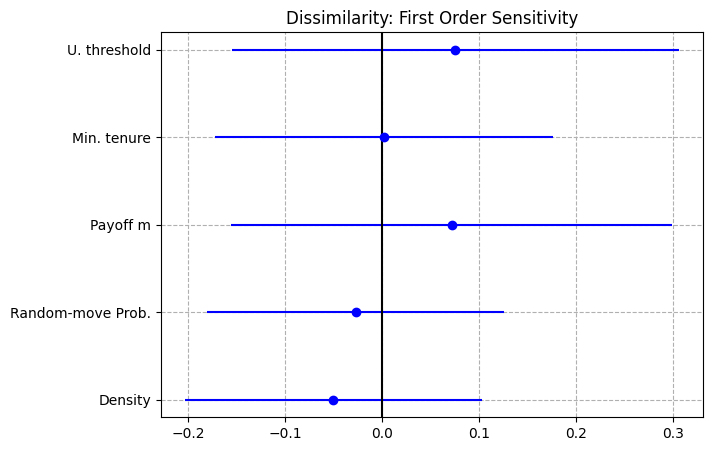

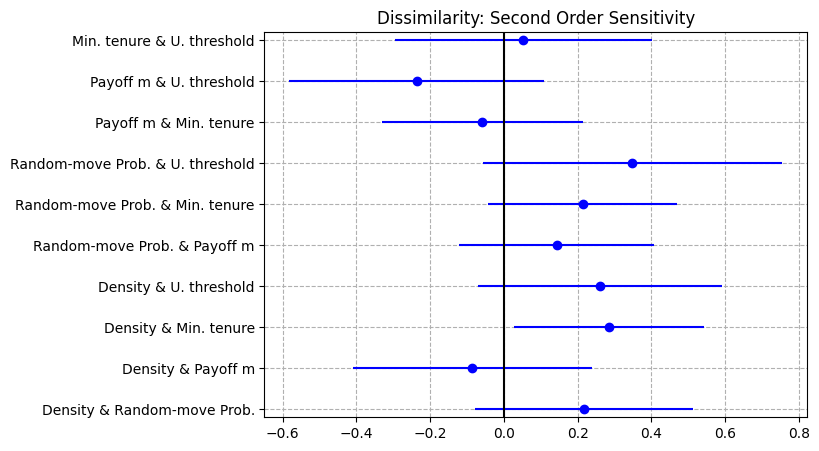

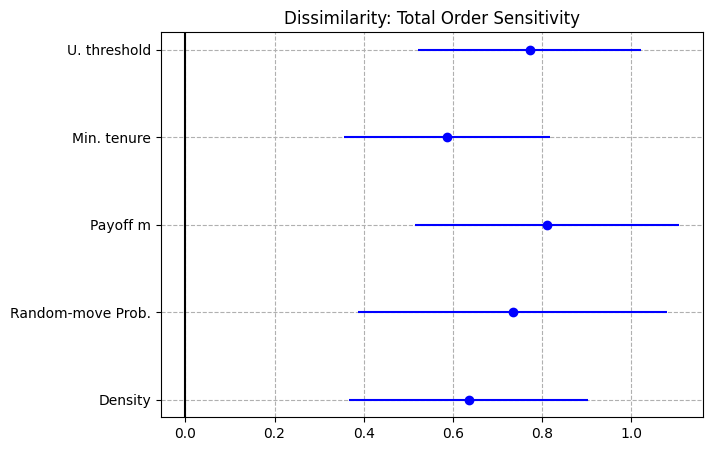

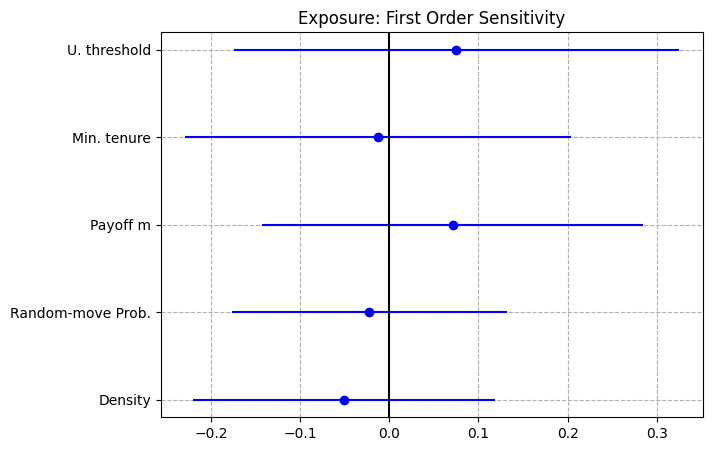

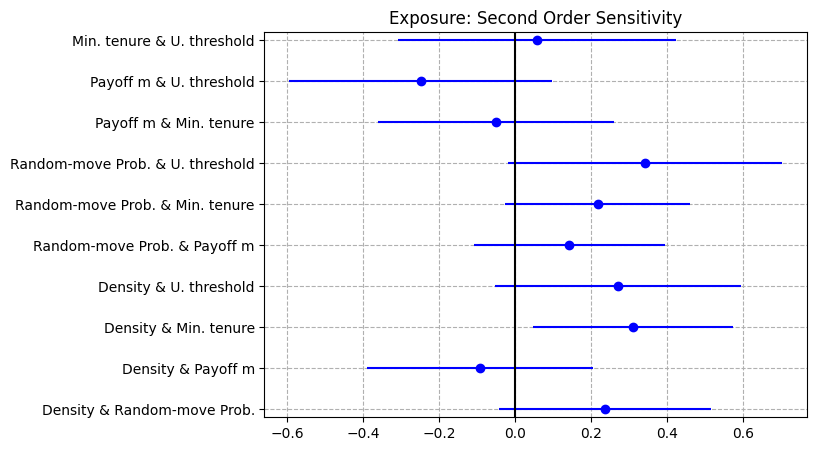

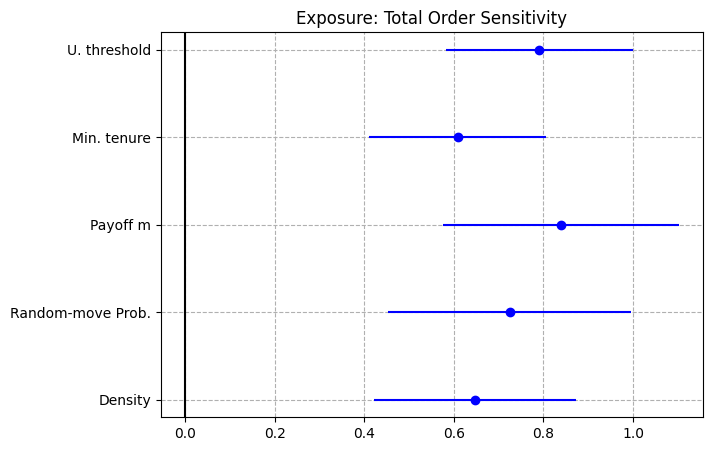

In [5]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(single_labels)
        # params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']

    l = len(indices)

    plt.figure(figsize=(7,5))
    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o', color='blue')
    plt.axvline(0, c='k')
    plt.grid(ls='dashed')



for Si, metric in zip((Si_dissimilarity, Si_exposure), ('Dissimilarity', 'Exposure')):
    # First order
    plot_index(Si, single_labels, '1', f'{metric}: First Order Sensitivity')
    plt.show()

    # Second order
    plot_index(Si, pair_labels, '2', f'{metric}: Second Order Sensitivity')
    plt.show()

    # Total order
    plot_index(Si, single_labels, 'T', f'{metric}: Total Order Sensitivity')
    plt.show()